In [1]:
import os
working_dir= os.getcwd()

# %autoreload makes Jupyter to reload modules before executing the cell
%load_ext autoreload
%autoreload 2

In [2]:
os.chdir("../src")
from MicrobiotaGAN.generator import Generator
from MicrobiotaGAN.discriminator import Discriminator
from MicrobiotaGAN.cost import wasserstein_generator_cost
from MicrobiotaGAN.cost import wasserstein_discriminator_cost
from MicrobiotaGAN.input_noise_sample import input_noise_sample
from MicrobiotaGAN.dataset_manager import DataSetManager 
from MicrobiotaGAN.glv_loss import GLV_Model
from MicrobiotaGAN.utilities import *
from MicrobiotaGAN.computational_graphs import *

os.chdir(working_dir)

In [3]:
import tensorflow as tf 

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
import numpy as np
import pandas as pd


from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle

import seaborn as sns
 
sns.set()
from timeit import default_timer as timer

In [ ]:


microbiota_table = pd.read_csv('../data/abundances.csv',header=None  ).values

 
    
param_path = '../data/image_dynamics_param.pickle' 

with open(param_path, 'rb') as pickleFile:
    microbiota_parameters = pickle.load(pickleFile)

# Splitting data into training set and test set

In [ ]:
# Load Data to the data mangaer

# Reduce data amount for quick training

microbiota_table = microbiota_table[0:10000]
#microbiota_table = np.multiply(microbiota_table, 0.1)

np.random.shuffle(microbiota_table)

training_percent = 0.9

lim = int(np.ceil(microbiota_table.shape[0]*training_percent))
train_set = microbiota_table[0:lim,:]
test_set = microbiota_table[lim:,:]
print("Test set" +str(test_set.shape))
print("Train set: "+str(train_set.shape))


microbiota_test_set =  DataSetManager(test_set, norm=False)
microbiota_train_set=  DataSetManager(train_set, norm=False)

m_sigma = microbiota_parameters['sigma']
m_rho = microbiota_parameters['rho']

print("\n")
print("Sigma: "+str(m_sigma))
print("Rho: "+str(m_rho))

m_A = microbiota_parameters['A']

m_r = microbiota_parameters['r']

n_species = m_A.shape[0]

Test set(1000, 50)
Train set: (9000, 50)


Sigma: 0.6
Rho: 0.1


In [ ]:
#np.std(mbio_dict["max_vec"], ddof=1) 
#x = microbiota_test_set.next_batch(1)
#print(np.sum(x[0,:]))
#print(np.max(x[0,:]))

In [ ]:
microbiota_parameters.keys()

dict_keys(['N', 'rho', 'sigma', 'mu', 'T_f', 'A', 'r'])

# Dataset exploration 

Distance from origin: 0.6082762530298219


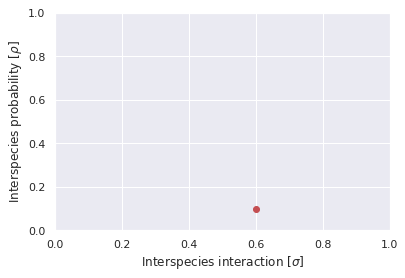

In [ ]:

plt.axis(xmax=1, ymax=1)
plt.plot(m_sigma, m_rho,'ro')
 
plt.xlabel(r'Interspecies interaction [$\sigma$]') 
plt.ylabel(r'Interspecies probability [$\rho$]')

print("Distance from origin: "+ str(np.sqrt(m_rho**2 + m_sigma**2)))

Text(0.5,1,'A Matrix')

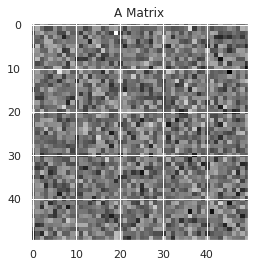

In [ ]:
plt.imshow(microbiota_parameters['A'], cmap="gray_r")
plt.title("A Matrix")

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


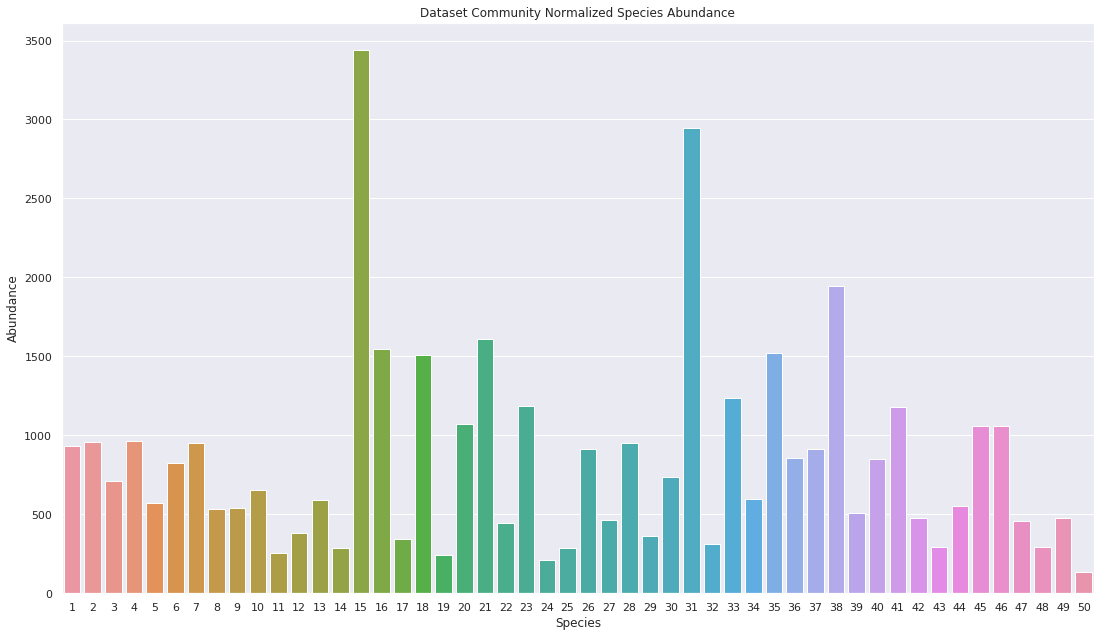

In [ ]:
# Micorbiota abundance pseudo histogram
print(list(range(1,m_A.shape[0])))

sns.barplot(x = list(range(1,m_A.shape[0]+1)) ,y= np.sum(normalize_ds(microbiota_table), axis=0))
plt.title("Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Computational Graph Definition

In [ ]:
n_species : int = m_A.shape[0]
mini_batch_size : int =32

noise_dim : int = 10
noise_sample = tf.placeholder(tf.float32, shape=[None, noise_dim])


# Computation Graph Definition
my_generator = Generator(noise_dim, n_species)
my_discriminator = Discriminator(n_species)

 
train_real_sample, train_noise_sample,  G_cost_train, G_train_step, D_cost_train, D_train_step,clip_D , D_logit_real_train,  D_logit_fake_train  = train_graph(my_discriminator, my_generator, n_species,noise_dim )
 

# inference_real_sample, inference_noise_sample, G_cost_inference, D_cost_inference, clip_D= inference_graph(my_discriminator, my_generator, n_species,noise_dim )


In [ ]:
# Initialize the network graph
# sess = tf.InteractiveSession() # tf.Session()
# sess.run(tf.global_variables_initializer())

In [ ]:
print(train_real_sample)
print("####")

print(G_train_step)
print("####")
print(G_cost_train)

Tensor("train_real_sample:0", shape=(?, 50), dtype=float32)
####
name: "RMSProp_1"
op: "NoOp"
input: "^RMSProp_1/update_G_W1/ApplyRMSProp"
input: "^RMSProp_1/update_G_W2/ApplyRMSProp"
input: "^RMSProp_1/update_G_b1/ApplyRMSProp"
input: "^RMSProp_1/update_G_b2/ApplyRMSProp"

####
Tensor("Neg:0", shape=(), dtype=float32)


#Train Loop


In [ ]:
number_of_fig_per_plot :int = 16
# Training Loop
counter = 0
d_iter_ratio: int = 5

train_epochs = 100

iters_per_epoch = train_set.shape[0]//mini_batch_size

iteration_number = train_epochs*iters_per_epoch
# Since the discriminator is trained 5 times more, de divide the number of iterations
iteration_number = int(np.ceil(iteration_number/d_iter_ratio))

start = timer()

train_g_cost_record = []
train_d_cost_record = []
iter_record_g = []
iter_record_d = []

epoch_record_g = []
epoch = []

g_train_epoch_cost = []
d_train_epoch_cost =[]
 

initial_epochs = microbiota_train_set.epochs_completed

little_record = []

add_g_record = 0
D_current_cost = 0
G_current_cost = 0

gen_logit = []
dis_logit = []

#### Sess 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    it = 0
    while microbiota_train_set.epochs_completed - initial_epochs < train_epochs:

        it += 1

        if microbiota_train_set.epochs_completed == 2:
            little_record.append(sess.run(my_generator.G_W1))

        # Train more the discriminator
        for k in range(d_iter_ratio):      

            previous_epoch = microbiota_train_set.epochs_completed
            real_sample_mini_batch = microbiota_train_set.next_batch(mini_batch_size)
            current_epoch = microbiota_train_set.epochs_completed
            
            noisy1 = input_noise_sample(mini_batch_size, noise_dim)
            
            """
            print("Discriminator data")
            real_string = str(np.sum(real_sample_mini_batch))+" "+str(real_sample_mini_batch.shape) 
            fale_string = str(np.sum(noisy1))+" "+str(noisy1.shape) 
            print("Real "+real_string+" fake "+fale_string)
            """
            
            dis_var_dict = {train_real_sample  : real_sample_mini_batch,
                            train_noise_sample :  noisy1
                           }
            
            D_train_step.run(feed_dict=dis_var_dict)
            D_current_cost, _ = sess.run([D_cost_train, clip_D], feed_dict=dis_var_dict)
            
            # ======> Debug logits <===========
            #dis_logit.append(sess.run([D_logit_fake_train], feed_dict=dis_var_dict))
            #gen_logit.append(sess.run([D_logit_real_train], feed_dict=dis_var_dict))
            # dis_logit.append(sess.run([norm_logit_t_fake,  D_logit_fake_train, fake_L1_output ], feed_dict=dis_var_dict))
            # gen_logit.append(sess.run([norm_logit_t_real,  D_logit_real_train,  real_L1_output], feed_dict=dis_var_dict))
            # ======> Debug logits <===========
            
            train_d_cost_record.append(D_current_cost)
            iter_record_d.append(it+1+k)

            if current_epoch > previous_epoch :
                d_train_epoch_cost.append(D_current_cost)
                add_g_record =1
                # g_train_epoch_cost.append(G_current_cost)

        # End For
        noisy2 = input_noise_sample(mini_batch_size, noise_dim)
        # Apply the optimization algorithm and update both network parameters
        gen_var_dict = {train_noise_sample:noisy2 }
        #_, G_current_cost = sess.run([G_train_step, G_cost_train], feed_dict=gen_var_dict)    
        G_train_step.run(feed_dict=gen_var_dict)       
               
        G_current_cost =  sess.run([ G_cost_train], feed_dict=gen_var_dict)   
       
        #print(G_current_cost)
        #print("noise: "+str(np.sum(noisy)))

        
        G_current_cost = G_current_cost[0]
        
        train_g_cost_record.append(G_current_cost)

        if add_g_record == 1:
            g_train_epoch_cost.append(G_current_cost)
            add_g_record = 0

        iter_record_g.append(it)

        if it % (iteration_number//10) == 0 or it == 0:
            end = timer()
            print("Progreso :"+str(100*it/(1.0*iteration_number))+" %")
            print(str(end - start)+" s")

            current_gen_weights = np.sum(sess.run(my_generator.G_W1))
            current_dis_weights = np.sum(sess.run(my_discriminator.D_W1))

            print("\t Current Gen Weights " +str(current_gen_weights))
            print("\t Current Dis Weights " +str(current_dis_weights))

            print("Epochs completed so far "+str(microbiota_train_set.epochs_completed))

            print('\t Iter: {}'.format(it))
            print('\t D loss: {:.4}'.format(D_current_cost))
            print('\t G_loss: {:.4}'.format(G_current_cost))
            print("\n")
            
            """
            print(len(dis_logit[-1][0]))
            print(type(dis_logit[-1]))
            print(np.sum(dis_logit[-1]))
            print(np.asarray(dis_logit[-1]).shape)
            print(np.sum(gen_logit[-1]))
        
            print(np.asarray(gen_logit[-1]).shape)
            print(np.mean(gen_logit[-1]))           
            
            
            
            print("Norm Logit Fake \t"+str(np.sum(dis_logit[-1][0])))
            print("Logit Fake \t"+str(np.sum(dis_logit[-1][1])))
            print("L1 Output Fake \t"+str(np.sum(dis_logit[-1][2])))

            print("Norm Logit Real \t"+str(np.sum(gen_logit[-1][0])))
            print("Logit Real \t"+str(np.sum(gen_logit[-1][1])))
            print("L1 Output Real \t"+str(np.sum(gen_logit[-1][2])))
            
            
            """
   

    saver = tf.train.Saver()
    saver.save(sess, '../results/trained_gan.ckpt')
    little_record.append(sess.run(my_generator.G_W1))

Progreso :10.0 %
10.29533265100008 s
	 Current Gen Weights -31.233093
	 Current Dis Weights -0.0068329517
Epochs completed so far 9
	 Iter: 562
	 D loss: 0.3436
	 G_loss: -0.04303


Progreso :20.0 %
19.266968525000266 s
	 Current Gen Weights -30.763536
	 Current Dis Weights -0.14988545
Epochs completed so far 19
	 Iter: 1124
	 D loss: 0.3682
	 G_loss: -0.03656


Progreso :30.0 %
27.870047057000193 s
	 Current Gen Weights -30.986217
	 Current Dis Weights -0.026731856
Epochs completed so far 29
	 Iter: 1686
	 D loss: 0.2527
	 G_loss: -0.0367


Progreso :40.0 %
35.88781370600009 s
	 Current Gen Weights -31.129723
	 Current Dis Weights -0.15614544
Epochs completed so far 39
	 Iter: 2248
	 D loss: 0.3208
	 G_loss: -0.039


Progreso :50.0 %
43.96830880300013 s
	 Current Gen Weights -31.206905
	 Current Dis Weights 0.051896155
Epochs completed so far 49
	 Iter: 2810
	 D loss: 0.3707
	 G_loss: -0.0411


Progreso :60.0 %
52.056524699999954 s
	 Current Gen Weights -31.214996
	 Current Dis Weight

In [ ]:
#print(np.sum(little_record[0]))
#print(np.sum(little_record[1]))

In [ ]:
#plt.plot(iter_record_g, g_cost_record)

In [ ]:
#plt.plot(iter_record_d, d_cost_record)

In [ ]:
!ls ../results/

In [ ]:

# Sample GAN loop

#tf.reset_default_graph()

#infer = Generator(noise_dim, n_species)

input_noise = tf.placeholder(tf.float32, shape=[None, noise_dim])
get_sample = my_generator.inference_draw_samples(input_noise)

sample_holder = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, '../results/trained_gan.ckpt')

    input_dict = {input_noise: input_noise_sample(1, noise_dim)}

    sample_holder.append(sess.run([get_sample], feed_dict=input_dict))

In [ ]:
print(sample_holder[0][0].shape)
print(GLV_Model(sample_holder[0][0],m_A, m_r))

In [ ]:
inference_real_sample, inference_noise_sample, G_cost_inference, D_cost_inference, clip_D = inference_graph(my_discriminator, my_generator, n_species,noise_dim )


# Test loop


In [ ]:
   

number_of_fig_per_plot :int = 16
#Training Loop
counter = 0

test_epochs = train_epochs

iters_per_epoch = test_set.shape[0]//mini_batch_size

test_iter =   test_epochs*iters_per_epoch



#test_iter =  (numero_de_iteraciones*test_set.shape[0])//train_set.shape[0]

start = timer()

test_g_cost_record = []
test_d_cost_record = []
iter_test_record_g = []
iter_test_record_d = []

 
g_test_epoch_cost = []
d_test_epoch_cost =[]
 

epoch_record_g = []
epoch = []

d_iter_ratio: int = 5
    
"""
print(iters_per_epoch)
print(test_iter)
print(test_set.shape[0])


"""
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'../results/trained_gan.ckpt')

    for it in range(test_iter):

        # Train more the discrimantor    
        for k in range(d_iter_ratio):      

            #f k%5 == 0 and k != 0:
                #pass

            real_sample_mini_batch = microbiota_test_set.next_batch(mini_batch_size)
            dis_var_dict = {inference_real_sample: real_sample_mini_batch,
                            inference_noise_sample: input_noise_sample(mini_batch_size, noise_dim)
                           }
            D_current_test_cost, _ = sess.run([ D_cost_inference, clip_D], feed_dict=dis_var_dict)
            test_d_cost_record.append(D_current_test_cost)
            iter_test_record_d.append(it+1+k)
            





        # End For



        # Apply the optimization algorithm and update both newtwork parameters
        gen_var_dict = {inference_noise_sample: input_noise_sample(mini_batch_size, noise_dim)}
        temp_g_cost = sess.run([ G_cost_inference], feed_dict=gen_var_dict)
        #Since is the single fetch
        G_current_test_cost = temp_g_cost[0]

        test_g_cost_record.append(G_current_test_cost)

        iter_test_record_g.append(it)

        if it%iters_per_epoch == 0 and (k !=0):
            d_test_epoch_cost.append(D_current_test_cost)
            g_test_epoch_cost.append(G_current_test_cost)

        if it % (test_iter//10) == 0:
            end = timer()
            print("Progreso :"+str(100*it/(1.0*test_iter))+" %")
            print(str(end - start)+" s")

            print("epochs completed "+str(microbiota_test_set.epochs_completed))
            print(it/(iters_per_epoch/5))


            print('\t Iter: {}'.format(it))
            print('\t D loss: {:.4}'.format(D_current_test_cost))
            print('\t G_loss: {:.4}'.format(G_current_test_cost))


# Generator Loss Graph

In [ ]:
iter_line = list(range(len(train_g_cost_record)))
test_iter_line = list(range(len(test_g_cost_record)))

epochs_list = list(range(len(g_test_epoch_cost)))

plt.plot(epochs_list, g_train_epoch_cost)
plt.plot(epochs_list, g_test_epoch_cost)
plt.legend(['train set', 'test set'], loc='upper right')

plt.xlabel("epochs")
plt.ylabel("Loss");
plt.title("Generator Loss (with batch norm)")

im_ratio = 18.5/10.5

fig = plt.gcf()
fig.set_size_inches(12, 12/im_ratio )

plt.savefig('../results/generator_loss.png', dpi=300)
#train_g_cost_record

In [ ]:
plt.plot(epochs_list, d_train_epoch_cost)
plt.plot(epochs_list, d_test_epoch_cost)

im_ratio = 18.5/10.5

fig = plt.gcf()
fig.set_size_inches(12, 12/im_ratio )

## Closer look on the interval [0,100]

In [ ]:
plt.title("Generator loss on test set")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(iter_line[0:100],test_g_cost_record[0:100])


# Discriminator Loss Graph

In [ ]:
iter_line_d = list(range(len(train_d_cost_record)))

plt.plot(epochs_list, d_train_epoch_cost)
plt.plot(epochs_list, d_test_epoch_cost)
plt.legend(['train set', 'test set'], loc='upper right') 
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Discriminator Loss (with batch norm)")

fig = plt.gcf()
fig.set_size_inches(12, 12/im_ratio )

plt.savefig('../results/discriminator_loss.png', dpi=300)

## Closer look on the interval [0,100]

In [ ]:
plt.title("Discriminator loss on test set")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(iter_line_d[0:100],test_d_cost_record[0:100])


# Saving the model and othe file management

In [ ]:

#Comprimimos todos los archivos que se regenraron al guardar el moelo y despues lo descargamos
!zip  bio_gan.zip bio_gan.*

files.download("bio_gan.zip")

In [ ]:
!ls

In [ ]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, '/content/trained_gan.ckpt')
    
    w1 = sess.run(my_generator.G_W1)
    b1 = sess.run(my_generator.G_b1)

    w2= sess.run(my_generator.G_W2)
    b2 = sess.run(my_generator.G_b2)



gen_weights_and_bias = [w1, b1, w2, b2]

print(w1)

In [ ]:
#import pickle

In [ ]:
with open('gen_param.pkl', 'wb') as f:
  pickle.dump(gen_weights_and_bias, f)

# Using the Generator to create some samples

In [ ]:
# generator_sample_inference = my_generator.inference_draw_samples(noise_sample)

noise_sample = tf.placeholder(tf.float32, shape=[None, noise_dim])
sample_nara = my_generator.inference_draw_samples(noise_sample)

    
n_samples = 10
samples_table = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver.restore(sess, '../results/trained_gan.ckpt')

    for k in range(n_samples):
        
        noisy3 ={noise_sample :input_noise_sample(1, 10)}         
        f_sam = sess.run(sample_nara, feed_dict=noisy3)
        
        samples_table.append(f_sam[0] )
        done_per =(k/(1.0*n_samples))*100
        #print(str(round(done_per,2))+"% has samples have been created")
        #print(k)
        if k%(n_samples//10)==0:
            print(str(done_per)+"% has samples have been created")

samples_table = np.array(samples_table)

In [ ]:
sumatorias = [ np.sum(samples_table[k,:]) for k in range(samples_table.shape[0])]

prome = [ np.mean(samples_table[k,:]) for k in range(samples_table.shape[0])]
print(sumatorias[0:5])
print(prome[0:5])
print(len(prome))

In [ ]:
samples_table = np.array(samples_table) 
    
    
ts_min = []
for row in range(samples_table.shape[0]):
    ts_min.append(np.min(samples_table[row,:]))
    
ts_max = []
for row in range(samples_table.shape[0]):
    ts_max.append(np.max(samples_table[row,:]))
    
ts_max = np.array(ts_max)
ts_min = np.array(ts_min)
    
new_samples_table =  []
for row in range(samples_table.shape[0]):

    _ = samples_table[row,:]*(ts_max[row]-ts_min[row])+ts_min[row]
    new_samples_table.append(_)
      
new_samples_table = np.array(new_samples_table)

 

glv_gen_errors = []
for k in range(samples_table.shape[0]):
    error = np.sum( GLV_Model(samples_table[k,:], m_A, m_r ))
    #print(error)
    glv_gen_errors.append(error)
    
glv_gen_errors = np.array(glv_gen_errors)

 

In [ ]:
print("GAN Samples: "+str(samples_table.shape[0]))
print("GAN mean GLV error : "+str(np.mean(glv_gen_errors)))
print("GAN GLV error std : "+str(np.std(glv_gen_errors)))

In [ ]:
sub = DataSetManager(train_set)

In [ ]:
sub_train_set = sub.next_batch(samples_table.shape[0]) #train_set[0:n_samples,:]

glv_train_errors = []
for k in range(sub_train_set.shape[0]):
    error = np.sum( GLV_Model(sub_train_set[k,:], m_A, m_r ))
    #print(error)
    glv_train_errors.append(error)
    
glv_train_errors = np.array(glv_train_errors)

glv_mean_e = np.round(np.mean(glv_train_errors),4)
glv_e_std = np.round(np.std(glv_train_errors),4)


print("Training Samples <Normalized>: "+str(samples_table.shape[0]))
print("Sub Train Set mean GLV error : "+str(glv_mean_e))
print("Sub Train Set error std : "+str(glv_e_std))

In [ ]:
diff_e = np.mean(glv_gen_errors)  - glv_mean_e 
diff_std = np.std(glv_gen_errors) - glv_e_std

print("Samples: "+str(samples_table.shape[0]))

print("GAN-Train mean GLV error : "+str(diff_e))
print("GAN-Train GLV error std : "+str(diff_std))

# print("% GAN-Train mean GLV error : "+str(100*diff_e/glv_mean_e))
# print("% GAN-Train GLV error std : "+str(100*diff_std/glv_e_std))


In [ ]:
np.sum(samples_table < 0)

In [ ]:
import pandas as pd

df = pd.DataFrame(samples_table)
with open('unormed.csv', 'a') as f:
    df.to_csv(f, header=False, index=False)
    
    

df = pd.DataFrame(new_samples_table)
with open('normalized.csv', 'a') as f:
    df.to_csv(f, header=False, index=False)    
    
!zip gan_samples.zip *.csv

#files.download("gan_samples.zip")

## Asessing the GLV error

In [ ]:
d = {'GAN': glv_gen_errors, 'Training': glv_train_errors }
df = pd.DataFrame(data=d)

ax = sns.boxplot( data=df)

plt.title("GLV Error, "+str(train_epochs)+" epochs , "+str(n_samples)+" samples draw")


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.savefig("glv_barplot.png")


In [ ]:
# !rm *.png
files.download("glv_barplot.png")

# Misc

In [ ]:
sns.barplot(x = list(range(1,51)) ,y= np.sum(normalize_ds(samples_table), axis=0))
plt.title("GAN-Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")
plt.savefig("fake.svg")

In [ ]:

rnd_index = np.random.randint(low=1, high=140000,size=100)
sub_ds = normalize_ds(microbiota_table)[rnd_index]

sns.barplot(x = list(range(1,29)) ,y= np.sum(sub_ds, axis=0))
plt.title("Dataset Community Normalized Species Abundance")
plt.xlabel("Species")
plt.ylabel("Abundance")
plt.savefig("real.svg")
 

In [ ]:
files.download("real.svg")
files.download("fake.svg")

In [ ]:
a_t = normalize_ds(samples_table)

In [ ]:
show_rounded_array(a_t[8,:],2)

In [ ]:
!zip  pics.zip *.svg
files.download("pics.zip")

In [ ]:
!head -n 20 MicrobiotaGAN/generator.py

In [ ]:
bool(1)

In [ ]:
dir(my_generator)

In [ ]:
def Diagonal_Matrix(input_vector):
     return np.multiply(np.identity(input_vector.shape[0]),input_vector)


In [ ]:
s_0 = normalize_ds(microbiota_table)[0]

res = np.multiply(Diagonal_Matrix(s_0), np.matmul(m_A,s_0)+m_rho)

print(res[0,:])

plt.imshow(res, cmap="gray")


"""
print(m_A.shape)
print(s_0.shape)
print(s_0)
"""


In [ ]:
!head -n 25 MicrobiotaGAN/glv_loss.py